<a href="https://colab.research.google.com/github/njainds/Colab_notebooks/blob/master/Kaggle_Toxic_Comments_Feb19/LSTM_different_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
print("Name of GPU : {}".format(torch.cuda.get_device_name(0)))
print("# of GPU : {}".format(torch.cuda.device_count()))


Name of GPU : Tesla K80
# of GPU : 1


In [0]:
import pandas as pd
import keras
from keras.layers import Conv1D, Conv2D
from keras import optimizers

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/kaggle_toxic_comments"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
glove.840B.300d.zip    test.csv		train.csv
sample_submission.csv  test_labels.csv	wiki-news-300d-1M-subword.vec.zip


In [0]:
test_labels=pd.read_csv("/content/drive/My Drive/kaggle_toxic_comments/test_labels.csv")
train=pd.read_csv("/content/drive/My Drive/kaggle_toxic_comments/train.csv")
test=pd.read_csv("/content/drive/My Drive/kaggle_toxic_comments/test.csv")
sample_submission=pd.read_csv("/content/drive/My Drive/kaggle_toxic_comments/sample_submission.csv")

In [0]:
pd.set_option('display.max_colwidth', 100)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [0]:
#train.obscene.value_counts()*100/len(train)
#{'toxic': 9.58%,'severe_toxic':0.1%,'obscene':5.2%,'threat':0.3%,'insult':5%,'identity_hate':0.88%}

#train[(train['toxic']==1) & (train['severe_toxic']==1)].head()
train[train['toxic']==1].identity_hate.value_counts()

0    13992
1     1302
Name: identity_hate, dtype: int64

In [0]:
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, linear_model, metrics

In [0]:
train.comment_text[10]

'"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such a

In [0]:
import plotly.plotly as py
py.sign_in('ninjaa', '0TCSY0cl4iHi3IJjm9HO')
import plotly.graph_objs as go
import plotly.tools as tools
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
train1_df = train[train["threat"]==1]
train0_df = train[train["threat"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["comment_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["comment_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)')
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~ninjaa/0 or inside your plot.ly account where it is named 'word-plots'


In [0]:
#!wget http://nlp.stanford.edu/data/glove.840B.300d.zip -P /content/drive/"My Drive"/kaggle_toxic_comments/
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip -P /content/drive/"My Drive"/kaggle_toxic_comments/

--2019-02-10 05:03:24--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 587879973 (561M) [application/zip]
Saving to: ‘/content/drive/My Drive/kaggle_toxic_comments/wiki-news-300d-1M-subword.vec.zip’

wiki-news-300d-1M-s 100%[===================>] 560.65M  12.8MB/s    in 45s     

2019-02-10 05:04:10 (12.5 MB/s) - ‘/content/drive/My Drive/kaggle_toxic_comments/wiki-news-300d-1M-subword.vec.zip’ saved [587879973/587879973]



In [0]:
## Number of words in the text ##
train["num_words"] = train["comment_text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["comment_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train["num_unique_words"] = train["comment_text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["comment_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train["num_chars"] = train["comment_text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["comment_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train["num_stopwords"] = train["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test["num_stopwords"] = test["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
train["num_punctuations"] =train['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train["num_words_upper"] = train["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train["num_words_title"] = train["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train["mean_word_len"] = train["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning:

Mean of empty slice.



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



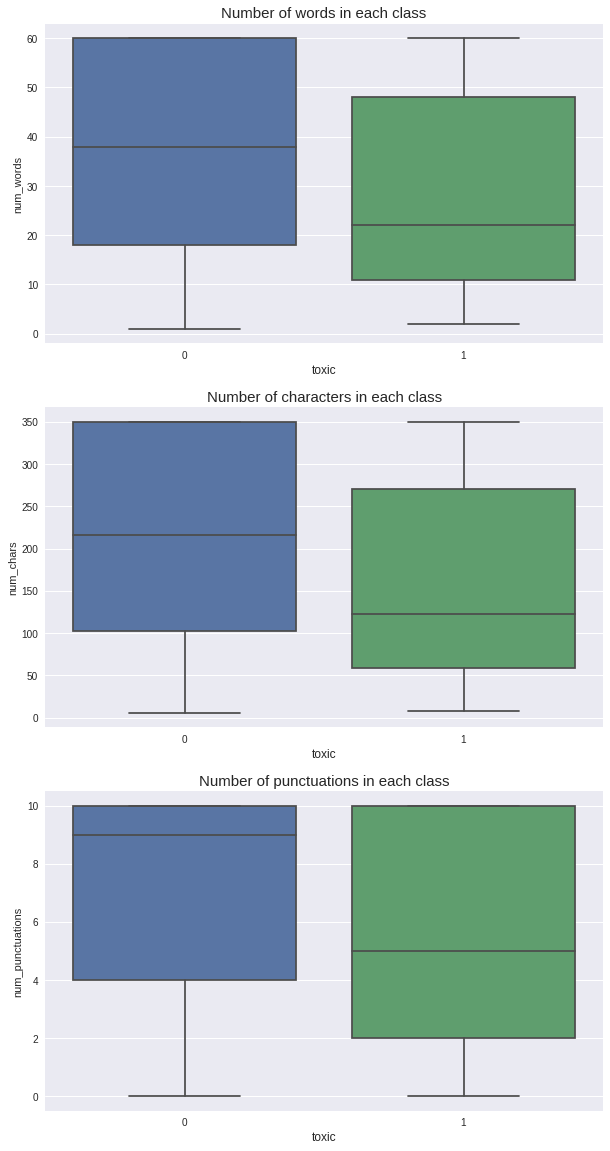

In [0]:
train['num_words'].loc[train['num_words']>60] = 60 #truncation for better visuals
train['num_punctuations'].loc[train['num_punctuations']>10] = 10 #truncation for better visuals
train['num_chars'].loc[train['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='toxic', y='num_words', data=train, ax=axes[0])
axes[0].set_xlabel('toxic', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='toxic', y='num_chars', data=train, ax=axes[1])
axes[1].set_xlabel('toxic', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='toxic', y='num_punctuations', data=train, ax=axes[2])
axes[2].set_xlabel('toxic', fontsize=12)
#plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

In [0]:
#Baseline model
# Get the tfidf vectors #
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,1),max_features=50000)
tfidf_vec.fit_transform(train['comment_text'].values.tolist() + test['comment_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['comment_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['comment_text'].values.tolist())

In [0]:

def runModel(train_X, train_y, test_X, test_y, test_X2):
    model = linear_model.LogisticRegression(C=5., solver='sag')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)[:,1]
    pred_test_y2 = model.predict_proba(test_X2)[:,1]
    return pred_test_y, pred_test_y2, model

label_auc_scores={}
test_labels.replace(-1,0,inplace=True)

for target in test_labels.columns.tolist()[1:]:
    train_y=np.asarray(train[target].values.tolist())
    print("Building model with target: {}".format(target))
    cv_scores = []
    #pred_full_test = 0
    pred_train = np.zeros([train.shape[0]])
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
    for dev_index, val_index in kf.split(train):
        dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        pred_val_y, pred_test_y, model = runModel(dev_X, dev_y, val_X, val_y, test_tfidf)
        test_labels[target] = test_labels[target] + pred_test_y/5
        pred_train[val_index] = pred_val_y
        cv_scores.append(metrics.roc_auc_score(val_y, pred_val_y))
    label_auc_scores[target]=np.mean(cv_scores)

Building model with target: toxic
Building model with target: severe_toxic
Building model with target: obscene
Building model with target: threat
Building model with target: insult
Building model with target: identity_hate


In [0]:
#{'toxic':0.9697, 'severe_toxic':0.9802, 'obscene':0.9839, 'threat':0.9887, 'insult':0.9731, 'identity_hate':0.9730}
cv_scores

[0.973093869992286]

In [0]:
import eli5
#!pip install eli5
eli5.show_weights(model, vec=tfidf_vec, top=100, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+25.524,fuck
+20.975,fucking
+17.203,idiot
+16.720,shit
+16.502,stupid
+14.567,bullshit
+13.941,ass
+12.803,suck
+12.706,asshole
+11.959,sucks


In [0]:
#test_labels.to_csv("/content/drive/My Drive/kaggle_toxic_comments/submission_baseline_lr.csv",index=None)
label_auc_scores

{'identity_hate': 0.973842101762596,
 'insult': 0.9733121166356788,
 'obscene': 0.9838192156071607,
 'severe_toxic': 0.9807739948379014,
 'threat': 0.9802070439289086,
 'toxic': 0.9693956391323708}